# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result. 

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$. 

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

In [1]:
import os
import json
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In [2]:
# from google.colab import drive/
# drive.mount('/content/drive')

In [ ]:
# !ls "/content/drive/My Drive/CV_FP"

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [ ]:
!mkdir -p /data/tusimple
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
!unzip train_set.zip -d /data/tusimple  #

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [3]:
DEFAULT_SIZE = (512, 256)
import torch
import torch.nn as nn


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path = "/data/tusimple/", 
                 sets = ["label_data_0313.json", "label_data_0531.json", "label_data_0601.json"],
                 size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.size = size
        self.means = np.array([103.939, 116.779, 123.68])
        self.all_data = []
        for dataset in sets:
            with open(os.path.join(dataset_path,dataset)) as f:
                self.all_data += [json.loads(line) for line in f.readlines()]
                
    def __get_label(self, lanes, h_samples, h, w):
        binary = np.zeros((h, w), dtype=np.uint8)
        instance = np.zeros((h, w), dtype=np.uint8)
        for n, lane in enumerate(lanes):
            prev = None
            for i in range(len(h_samples)):
                x = lane[i]
                y = h_samples[i]
                if x == -2:
                    prev = None
                    continue
                if prev:
                    cv2.line(binary, (x, y) , prev, 1, thickness = 10)
                    cv2.line(instance, (x, y) , prev, n+1, thickness = 10)
                prev = (x, y)
        binary = cv2.resize(binary, self.size, interpolation=cv2.INTER_NEAREST)  
        instance = cv2.resize(instance, self.size, interpolation=cv2.INTER_NEAREST)
        return binary, instance
        
    def __getitem__(self, idx):
        data = self.all_data[idx]
        
        img_path = data['raw_file']
        lanes = data["lanes"]
        h_samples = data["h_samples"]
        
        image = np.array(Image.open(os.path.join(self.dataset_path,img_path)), dtype=np.float32)[...,:3]
        h, w, c = image.shape
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)
        image -= self.means
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image/255).float() 
        
        binary, instance = self.__get_label(lanes, h_samples, h, w)
        
        binary = torch.from_numpy(binary).long()
        instance = torch.from_numpy(instance).long()
        return image, binary, instance
    
    def __len__(self):
        return len(self.all_data)

In [4]:
dataset = LaneDataset(dataset_path = '/app/data')

In [5]:
len(dataset)

3626

In [6]:
def plot_example(dataset):
    idnex = random.randint(0, len(dataset)-1)
    image, binary, instance = dataset[idnex]
    img_plot = (image.permute(1,2,0).numpy()*255+dataset.means).astype(np.uint8)
    plt.imshow(img_plot)
    plt.show()
    plt.imshow(binary.numpy())
    plt.show()
    plt.imshow(instance.numpy())
    plt.show()

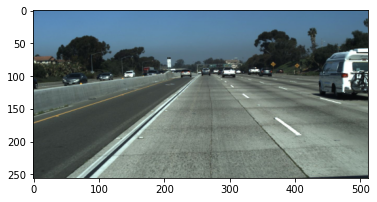

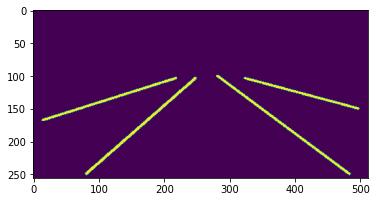

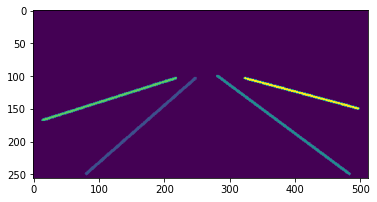

In [7]:
plot_example(dataset)

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [8]:
import torch.nn as nn
import torch

class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 padding=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=kernel_size,
            stride=2,
            padding=padding,
            bias=bias)

        self.ext_branch = nn.MaxPool2d(kernel_size, stride=2, padding=padding)

        self.batch_norm = nn.BatchNorm2d(out_channels)

        self.out_prelu = activation

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        out = torch.cat((main, ext), 1)

        out = self.batch_norm(out)

        return self.out_prelu(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation,
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation)
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation)

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        self.out_prelu = activation

    def forward(self, x):
        main = x

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        out = main + ext

        return self.out_prelu(out)


class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        self.return_indices = return_indices

        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        self.main_max1 = nn.MaxPool2d(
            kernel_size,
            stride=2,
            padding=padding,
            return_indices=return_indices)

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        self.out_prelu = activation

    def forward(self, x):
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        if main.is_cuda:
            padding = padding.cuda()

        main = torch.cat((main, padding), 1)

        out = main + ext

        return self.out_prelu(out), max_indices

class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation)

        self.ext_conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=2,
                padding=padding,
                output_padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        self.out_prelu = activation

    def forward(self, x, max_indices):
        main = self.main_conv1(x)
        main = self.main_unpool1(main, max_indices)
        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out)

In [9]:
class ENet(nn.Module):
    """
    ENET Encoder
    """

    def __init__(self, encoder_relu=False, decoder_relu=False):
        super(ENet,self).__init__()
        self.initial_block = InitialBlock(3, 16, padding=1, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(16, 64, padding=1, return_indices=True, dropout_prob=0.01,
                                                    relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(64, 128, padding=1, return_indices=True, dropout_prob=0.1,
                                                    relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1,
                                               relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1,
                                               relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1,
                                               relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1,
                                               relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0_s = UpsamplingBottleneck(
            128, 64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1_s = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2_s = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0_s = UpsamplingBottleneck(
            64, 16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1_s = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv_s = nn.ConvTranspose2d(
            16,
            2,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
            bias=False)
        
        # Stage 4 - Decoder
        self.upsample4_0_e = UpsamplingBottleneck(
            128, 64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1_e = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2_e = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0_e = UpsamplingBottleneck(
            64, 16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1_e = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv_e = nn.ConvTranspose2d(
            16,
            5,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
            bias=False)

    def forward(self, input):
         # Initial block
        x = self.initial_block(input)

        # Stage 1 - Encoder
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x_encode = self.dilated2_8(x)

        # Stage 4 - Decoder
        x = self.upsample4_0_s(x_encode, max_indices2_0)
        x = self.regular4_1_s(x)
        x = self.regular4_2_s(x)

        # Stage 5 - Decoder
        x = self.upsample5_0_s(x, max_indices1_0)
        x = self.regular5_1_s(x)
        y_segment = self.transposed_conv_s(x)

        # Stage 4 - Decoder
        x = self.upsample4_0_e(x_encode, max_indices2_0)
        x = self.regular4_1_e(x)
        x = self.regular4_2_e(x)

        # Stage 5 - Decoder
        x = self.upsample5_0_e(x, max_indices1_0)
        x = self.regular5_1_e(x)
        y_embbeding = self.transposed_conv_e(x)

        return y_segment, y_embbeding

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [10]:
def discriminative_loss_single(embedding, inst_label, delta_v, delta_d, param_var, param_dist, param_reg):
    c, h, w = embedding.size()
    if inst_label.is_cuda == True:
        device = 'cuda'
    else:
        device = 'cpu'

    # extract binary mask from instance label map for each class
    num_classes = len(torch.unique(inst_label)) - 1
    h, w = inst_label.shape
    inst_masks = torch.zeros(num_classes, h, w).byte().to(device)

    for idx, label in enumerate(torch.unique(inst_label)):
        if label == 0:  # deal with backgroud
            continue
        else:
            inst_masks[idx - 1] = (inst_label == label)

    embeddings = []
    # select embedding pixel with inst_label
    for i in range(num_classes):
        feature = torch.transpose(torch.masked_select(embedding, inst_masks[i, :, :]).view(c, -1), 0, 1)
        embeddings.append(feature)

    centers = []
    for feature in embeddings:
        center = torch.mean(feature, dim=0, keepdim=True)
        centers.append(center)

    # intra-embedding loss within a class
    loss_var = torch.Tensor([0.0]).to(device)
    for feature, center in zip(embeddings, centers):
        dis = torch.norm(feature - center, 2, dim=1) - delta_v
        dis = F.relu(dis)
        loss_var += torch.mean(dis)
    loss_var /= num_classes

    if num_classes == 1:
        return loss_var, loss_var, torch.zeros(1)  # .to(device)

    # inter-class loss
    centers = torch.cat(centers, dim=0)
    A = centers.repeat(1, num_classes).view(-1, c)
    B = centers.repeat(num_classes, 1)
    distance = torch.norm(A - B, 2, dim=1).view(num_classes, num_classes)

    # select pair wise distance from distance matrix
    eye = torch.eye(num_classes).to(device)
    pair_distance = torch.masked_select(distance, eye == 0)

    pair_distance = delta_d - pair_distance
    pair_distance = F.relu(pair_distance)
    loss_dist = torch.mean(pair_distance).view(-1)

    # regularization loss
    loss_reg = torch.mean(torch.norm(centers, 2, dim=1)).view(-1)

    loss = param_var * loss_var + param_dist * loss_dist + param_reg * loss_reg
    return loss, loss_var, loss_dist, loss_reg


def discriminative_loss(embedding_batch, label_batch,
                        delta_v=0.5,  # 0.5
                        delta_d=1.5,
                        param_var=1.0,
                        param_dist=1.0,
                        param_reg=0.001):
    loss, loss_v, loss_d, loss_r = 0, 0, 0, 0
    for embedding, inst_lbl in zip(embedding_batch, label_batch):
        _loss, _loss_v, _loss_d, _loss_r = \
            discriminative_loss_single(embedding, inst_lbl, delta_v, delta_d, param_var, param_dist, param_reg)

        loss += _loss
        loss_v += _loss_v
        loss_d += _loss_d
        loss_r += _loss_r

    return loss, loss_v, loss_d, loss_r

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [11]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-400, 400])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False, num_workers=8)

In [13]:
net = ENet().cuda()
net.load_state_dict(torch.load("Lane60.pth"))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
bin_criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

for epoch in range(30):
    total_loss_mean = []
    binary_loss_maen = []
    instance_loss_mean = []

    print('Train', epoch)
    net.train()
    for img, binary, instance in tqdm(train_loader):             
        img = img.cuda()
        binary_label = binary.long().cuda()
        instance_label = instance.cuda()
        
        optimizer.zero_grad()
        
        y_segment, y_embbeding = net(img)
        
        loss_bin = bin_criterion(y_segment, binary_label)
        
        loss_disc, loss_v, loss_d, loss_r = discriminative_loss(y_embbeding,
                                                            instance_label,
                                                            delta_v=0.2,
                                                            delta_d=1,
                                                            param_var=.5,
                                                            param_dist=.5,
                                                            param_reg=0.001)

        loss = loss_bin + loss_disc * 0.01
        loss.backward()
        optimizer.step()
        
        total_loss_mean.append(loss.item())
        binary_loss_maen.append(loss_bin.item())
        instance_loss_mean.append(loss_disc.item())

    print("total_loss_mean", sum(total_loss_mean)/len(total_loss_mean))
    print("binary_loss_maen", sum(binary_loss_maen)/len(binary_loss_maen))
    print("instance_loss_mean", sum(instance_loss_mean)/len(instance_loss_mean))
    
    net.eval()
    print('Val', epoch)
    for img, binary, instance in tqdm(val_loader):
        img = img.cuda()
        binary_label = binary.cuda()
        instance_label = instance.cuda()

        net_output = net(img)
        
        y_segment, y_embbeding = net(img)
        
        loss_bin = bin_criterion(y_segment, binary_label)
        
        loss_disc, loss_v, loss_d, loss_r = discriminative_loss(y_embbeding,
                                                            instance_label,
                                                            delta_v=0.2,
                                                            delta_d=1,
                                                            param_var=.5,
                                                            param_dist=.5,
                                                            param_reg=0.001)

        loss = loss_bin + loss_disc * 0.01
        
        total_loss_mean.append(loss.item())
        binary_loss_maen.append(loss_bin.item())
        instance_loss_mean.append(loss_disc.item())
        
    print("total_loss_mean", sum(total_loss_mean)/len(total_loss_mean))
    print("binary_loss_maen", sum(binary_loss_maen)/len(binary_loss_maen))
    print("instance_loss_mean", sum(instance_loss_mean)/len(instance_loss_mean))

In [ ]:
torch.save(net.state_dict(), "Lane60.pth")

# Example

In [14]:
net = ENet().cuda()
net.load_state_dict(torch.load("Lane60.pth"))
net.eval()
print("SUCCESS")

SUCCESS


In [15]:
img, binary, instance = val_set[2]
img = torch.unsqueeze(img, 0)

In [16]:
logit, embeddings = net(img.cuda())

In [17]:
img = (img).squeeze().permute(1, 2, 0).cpu() + torch.tensor(dataset.means/255)
pred = (torch.argmax(logit, dim=1)).squeeze().cpu()
embeddind_layers = embeddings.squeeze().argmax(dim=0).cpu()

# Pred + True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


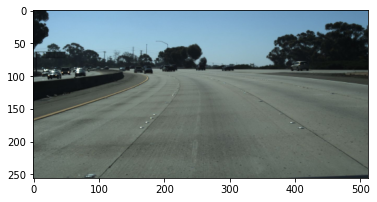

Text(0.5, 1.0, 'True instance')

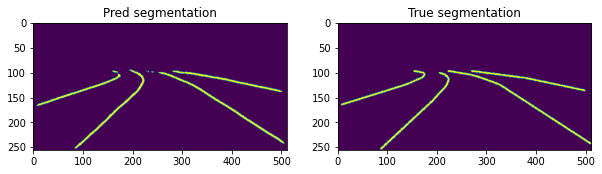

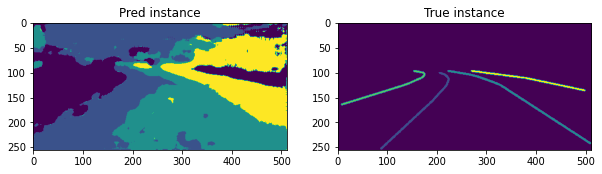

In [18]:
plt.imshow(img)
plt.show()
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.imshow(pred)
ax1.set_title("Pred segmentation")

ax2.imshow(binary)
ax2.set_title("True segmentation")
fig.show()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.imshow(embeddind_layers)
ax1.set_title("Pred instance")

ax2.imshow(instance)
ax2.set_title("True instance")

In [19]:
embeddind_layers

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 4, 4]])

### 2.2.3 Creating a customized dataset class in pytorch

In [20]:
HNET_DEFAULT_SIZE = (128, 64)

class HNetDataset(torch.utils.data.Dataset):
    def __init__(self, json_files, is_training=True):
        self.is_training = is_training
        self.img_list, self.gt_pts_list = self._init_dataset(json_files)
        self.means = np.array([103.939, 116.779, 123.68])
        self.size = HNET_DEFAULT_SIZE
        
    def _init_dataset(self, json_files):
        img_list = []
        gt_pts_list = []

        if self.is_training:
            for json_file in json_files:
                assert os.path.exists(json_file), 'File {} does not exist!'.format(json_file)

                src_dir = os.path.split(json_file)[0]
                with open(json_file, 'r') as file:
                    for line in file:
                        info_dict = json.loads(line)
                        img_path = os.path.join(src_dir, info_dict['raw_file'])
                        assert os.path.exists(img_path), 'File {} does not exist!'.format(img_path)

                        img_list.append(img_path)

                        h_samples = info_dict['h_samples']
                        lanes = info_dict['lanes']

                        lane_pts = []
                        for lane in lanes:
                            assert len(h_samples) == len(lane)
                            for x, y in zip(lane, h_samples):
                                if x == -2:
                                    continue
                                lane_pts.append([x, y, 1])
                            if not lane_pts:
                                continue
                            if len(lane_pts) <= 3:
                                continue
                        gt_pts_list.append(lane_pts)
            return img_list, gt_pts_list
        else:
            for json_file in json_files:
                assert os.path.exists(json_file), 'File {} does not exist!'.format(json_file)

                src_dir = os.path.split(json_file)[0]
                with open(json_file, 'r') as file:
                    for line in file:
                        info_dict = json.loads(line)
                        img_path = os.path.join(src_dir, info_dict['raw_file'])
                        assert os.path.exists(img_path), 'File {} does not exist!'.format(img_path)

                        img_list.append(img_path)
            return img_list

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img_path = self.img_list[index]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.size, interpolation=cv2.INTER_LINEAR)
        img = np.asarray(img).astype(np.float32)
        img -= self.means
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img)

        if not self.is_training:
            return {'input_tensor': img}

        gt_pts = self.gt_pts_list[index]
        gt_pts = np.array(gt_pts).reshape((-1, 3))
        gt_pts = torch.from_numpy(gt_pts)

        sample = {'input_tensor': img, 'gt_points': gt_pts}
        
        return sample

In [21]:
hdataset = HNetDataset(["/app/data/label_data_0313.json","/app/data/label_data_0531.json","/app/data/label_data_0601.json"])

tensor([[632, 280,   1],
        [625, 290,   1],
        [617, 300,   1],
        [609, 310,   1],
        [601, 320,   1],
        [594, 330,   1],
        [586, 340,   1],
        [578, 350,   1],
        [570, 360,   1],
        [563, 370,   1]])


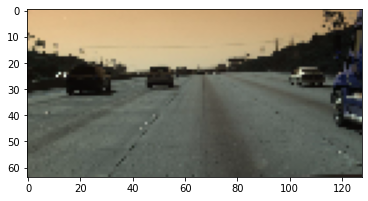

In [22]:
print(hdataset[0]['gt_points'][:10])
plt.imshow((hdataset[0]['input_tensor'].permute(1,2,0)+torch.tensor(hdataset.means))/255)

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [23]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [24]:
from matplotlib import pyplot as plt
import cv2

In [25]:
image = plt.imread('1.jpeg')

In [26]:
image = cv2.resize(image, (128, 64))

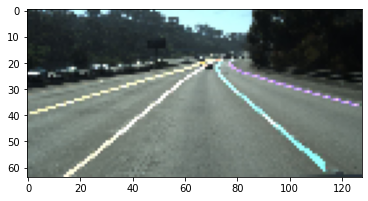

In [27]:
plt.imshow(image)

In [28]:
R_np = R.numpy()

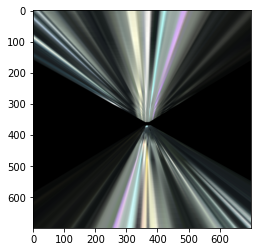

In [29]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [30]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        self.num_blocks = 3
        self.in_channels = [3, 16, 32]
        self.out_channels = [16, 32, 64]

        layers = []
        for i in range(self.num_blocks):
            in_channels = self.in_channels[i]
            out_channels = self.out_channels[i]
            layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))

            layers.append(nn.Conv2d(out_channels, out_channels, 3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))

            layers.append(nn.MaxPool2d(2))

        self.conv = nn.Sequential(*layers)
        self.fc = nn.Sequential(nn.Linear(64 * 16 * 8, 1024), nn.ReLU(inplace=True), nn.Linear(1024, 6))
    
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, 64 * 16 * 8))
        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through. 
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [31]:
class HNetLoss(object):
    def __init__(self):
        self.device = torch.device('cuda')

    def hnet_loss_single(self, pts_gt, trans_coef):
        if torch.cuda.is_available():
            pts_gt = pts_gt.cuda()
            trans_coef = trans_coef.cuda()

        pts_gt = pts_gt.view(-1, 3)
        trans_coef = trans_coef.view(6)
        trans_coef = torch.cat([trans_coef, torch.tensor([1.0], device = self.device)])
        H_indices = torch.tensor([0, 1, 2, 4, 5, 7, 8], dtype=torch.long, device = self.device)
        H = torch.zeros(9, dtype=torch.float32, device = self.device).scatter_(0, H_indices, trans_coef).view(3, 3)

        pts_gt = pts_gt.view(-1, 3).to(torch.float32).t()  # (3 * n)
        pts_projected = torch.mm(H, pts_gt)

        # least squares closed-form solution
        X = pts_projected[0, :].view(-1, 1)  # (n * 1)
        Y = pts_projected[1, :].view(-1, 1)  # (n * 1)
        Y_mat = torch.cat([torch.pow(Y, 3), torch.pow(Y, 2), Y, torch.ones_like(Y, dtype=torch.float32)],
                          dim=1)  # (n * 4)
        w = Y_mat.t().mm(Y_mat).inverse().mm(Y_mat.t()).mm(X)  # (4 * 1)

        # re-projection and compute loss

        x_pred = torch.mm(Y_mat, w)  # (n * 1)
        pts_pred = torch.cat([x_pred, Y, torch.ones_like(Y, dtype=torch.float32)], dim=1).t()  # (3 * n)
        pts_back = torch.mm(H.inverse(), pts_pred)

        loss = torch.mean(torch.pow(pts_back[0, :] - pts_gt[0, :], 2))

        return loss

    def hnet_loss(self, pts_batch, coef_batch):
        if torch.cuda.is_available():
            pts_batch = pts_batch.cuda()
            coef_batch = coef_batch.cuda()

        batch_size = coef_batch.size()[0]

        loss_acc = torch.zeros(batch_size, dtype=torch.float32)

        for i in range(batch_size):
            loss_acc[i] = self.hnet_loss_single(pts_batch[i], coef_batch[i])

        loss = torch.mean(loss_acc)
        return loss

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [40]:
train_set, val_set = torch.utils.data.random_split(hdataset, [len(dataset)-400, 400])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=8)

In [41]:
hnet = HNet().cuda()
optimizer = torch.optim.SGD(hnet.parameters(), lr = 1e-8)
criterion = HNetLoss()

In [42]:
def preprocess(img):
    R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])
    R = R.numpy()
    img = img[0].cpu().numpy()
    img = cv2.warpPerspective(img, R_np, dsize=(700, 700))
    img = cv2.resize(img, (128, 64))
    return torch.from_numpy(img).unsqueeze(0)

In [43]:
for epoch in range(5):
    mean_loss = []
    step = 1
    batch_step = 1
    optimizer.zero_grad()
    for data in tqdm(train_loader):

        img = preprocess(data['input_tensor']).cuda()

        out = hnet(data['input_tensor'].cuda())
        loss = criterion.hnet_loss(data['gt_points'].cuda(), out.view(-1,6))
        loss.backward()
        mean_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
    batch_step = 1
    print(sum(mean_loss)/len(mean_loss))
    mean_loss = []

100%|██████████| 3226/3226 [01:39<00:00, 32.30it/s]


38851437327.74952


100%|██████████| 3226/3226 [01:38<00:00, 32.72it/s]


nan


 20%|██        | 649/3226 [00:20<01:21, 31.63it/s]


KeyboardInterrupt: 

# 2. Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [35]:
def fit_lanes(inst_pred):
    """
    :param inst_pred: lane instances prediction map, support single image
    :return: A list of each curve's parameter
    """
    assert inst_pred.dim() == 2

    h, w = inst_pred.shape


    inst_pred_expand = inst_pred.view(-1)

    inst_unique = torch.unique(inst_pred_expand)

    # extract points coordinates for each lane
    lanes = []
    for inst_idx in inst_unique:
        if inst_idx != 0:
            lanes.append(torch.nonzero(inst_pred == inst_idx).cpu().numpy())

    curves = []
    for lane in lanes:
        pts = lane

        # fitting each lane
        curve = np.polyfit(pts[:, 0], pts[:, 1], 3)
        curves.append(curve)

    return curves


def sample_from_curve(curves, inst_pred, y_sample):
    """
    :param curves: A list of each curve's parameter
    :param inst_pred: lane instances prediction map, support single image
    :return: A list of sampled points on each curve
    """
    h, w = inst_pred.shape
    curves_pts = []
    for param in curves:
        # use new curve function f(y) to calculate x values
        fy = np.poly1d(param)
        x_sample = fy(y_sample)

        '''Filter out points beyond image boundaries'''
        index = np.where(np.logical_or(x_sample < 0, x_sample >= w))
        x_sample[index] = -2

        '''Filter out points beyond predictions'''
        # may filter out bad point, but can also drop good point at the edge
        index = np.where((inst_pred[y_sample, x_sample] == 0).cpu().numpy())
        x_sample[index] = -2

        xy_sample = np.vstack((x_sample, y_sample)).transpose((1, 0)).astype(np.int32)

        curves_pts.append(xy_sample)

    return curves_pts

def cluster_embed(embeddings, preds_bin, band_width):
    c = embeddings.shape[1]
    n, _, h, w = preds_bin.shape
    preds_bin = preds_bin.view(n, h, w)
    preds_inst = torch.zeros_like(preds_bin)
    for idx, (embedding, bin_pred) in enumerate(zip(embeddings, preds_bin)):
        embedding_fg = torch.transpose(torch.masked_select(embedding, bin_pred.byte()).view(c, -1), 0, 1)
        clustering = DBSCAN(eps=0.3).fit(embedding_fg.cpu().detach().numpy())
        preds_inst[idx][bin_pred.byte()] = torch.from_numpy(clustering.labels_).cuda() + 1
    return preds_inst


color_set = [(0, 0, 0),
    (60, 76, 231), (18, 156, 243), (113, 204, 46), (219, 152, 52), (182, 89, 155),
    (94, 73, 52), (0, 84, 211), (15, 196, 241), (156, 188, 26), (185, 128, 41),
    (173, 68, 142), (141, 140, 127), (43, 57, 192), (34, 126, 230), (96, 174, 39),
    (241, 240, 236), (166, 165, 149), (199, 195, 189), (80, 62, 44), (133, 160, 22),
]


def get_color(idx):
    return color_set[idx]

In [36]:
from sklearn.cluster import DBSCAN

1 GPUs!



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


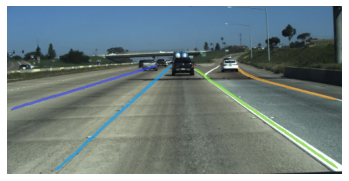

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


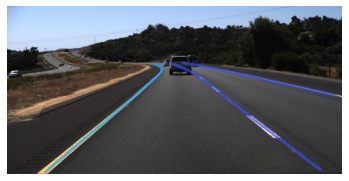

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


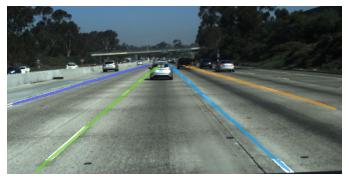

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


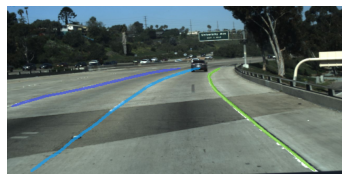

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


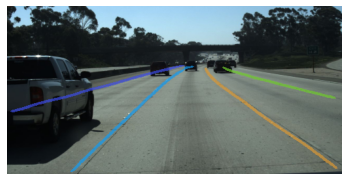

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


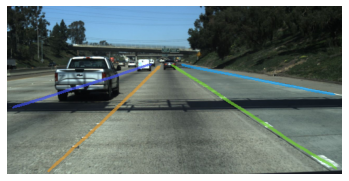

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


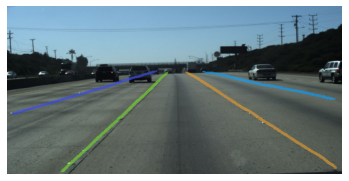

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


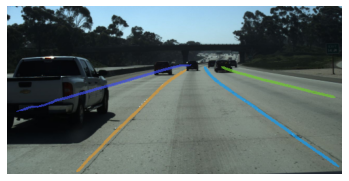

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


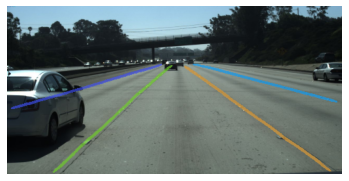

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


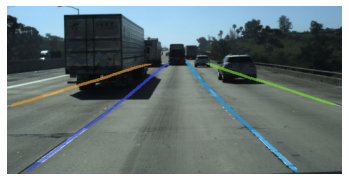

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


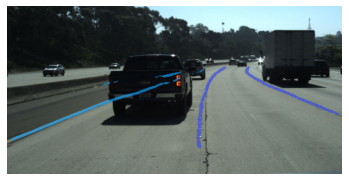

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


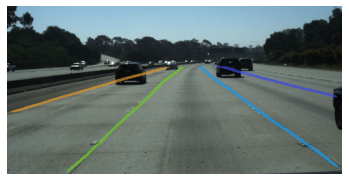

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


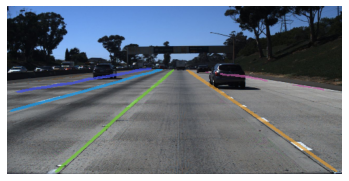

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


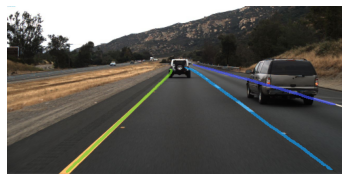

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


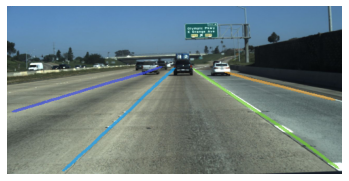

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


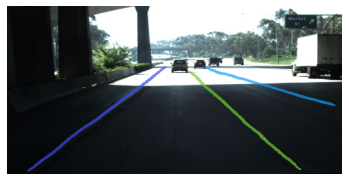

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


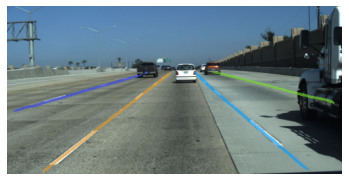

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


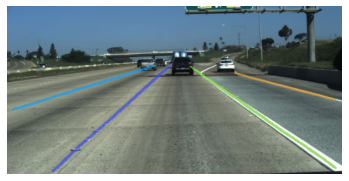

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


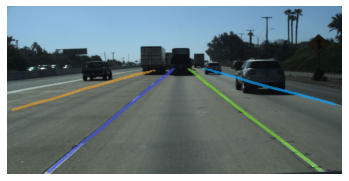

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


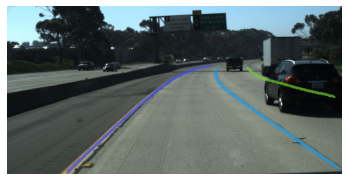

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


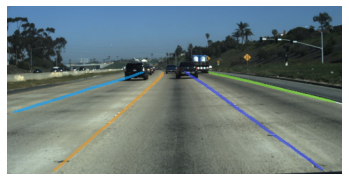

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


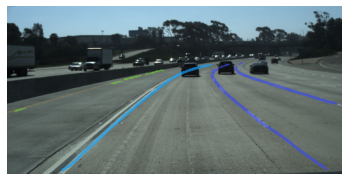

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


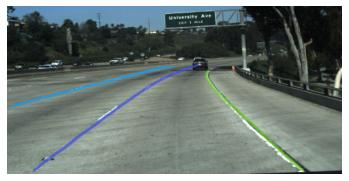

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


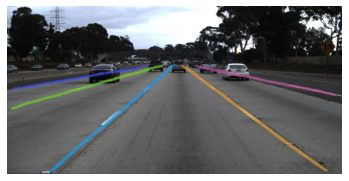

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


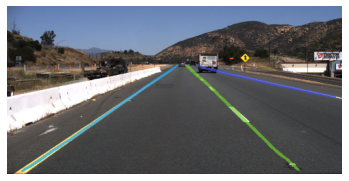

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


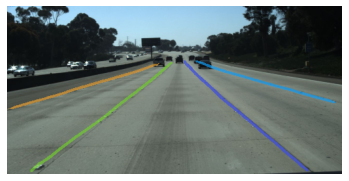

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


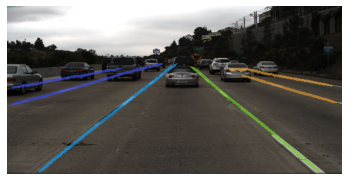

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


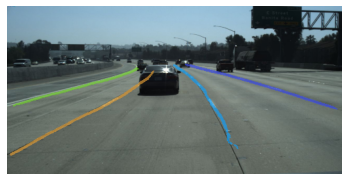

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


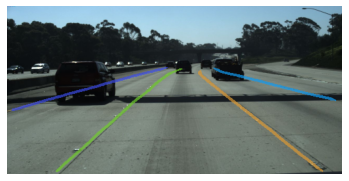

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RankWarning: Polyfit may be poorly conditioned


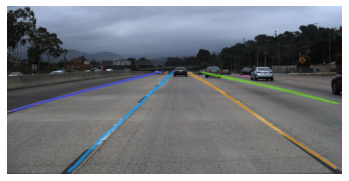

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


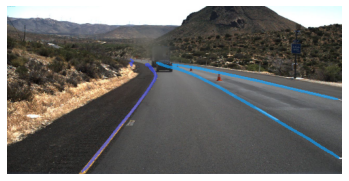

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


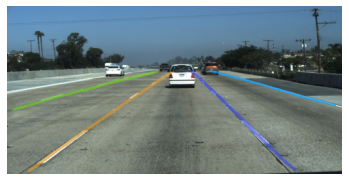

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


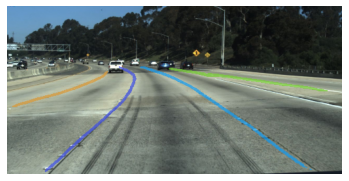

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


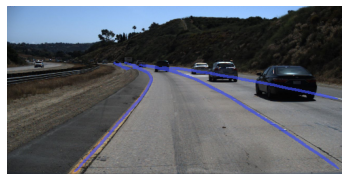

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


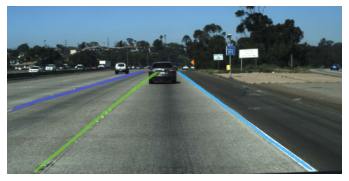

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


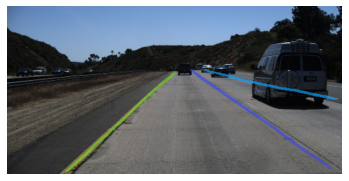

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


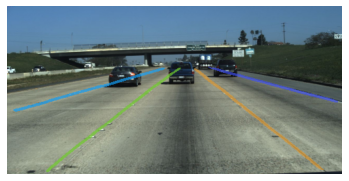

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


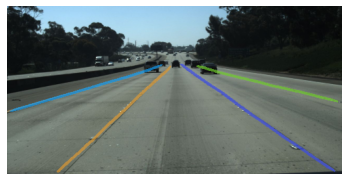

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


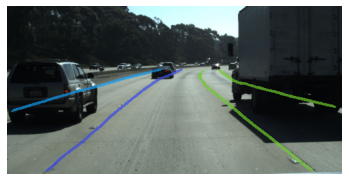

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


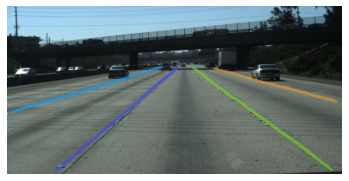

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


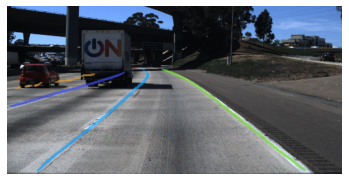

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


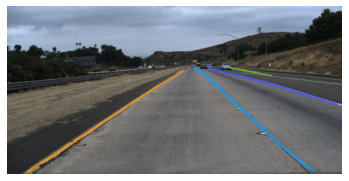

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


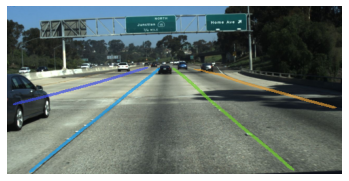

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


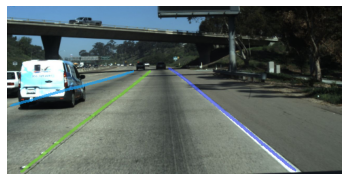

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


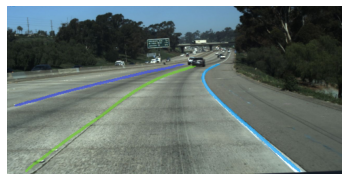

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


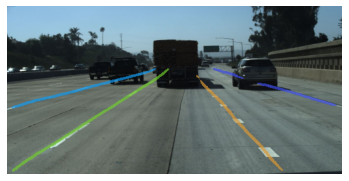

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


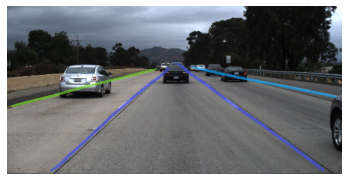

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


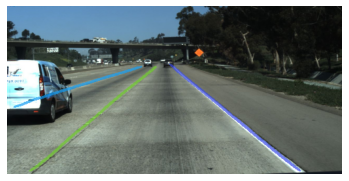

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


KeyboardInterrupt: 

In [37]:
batch_size = 1
num_workers = 2

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    batch_size *= torch.cuda.device_count()
    print(torch.cuda.device_count(), "GPUs!")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("CPU")

train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-400, 400])
test_set = val_set

num_test = len(test_set)

testset_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

dataloaders = {'test': testset_loader}
phase = 'test'

'''Constant variables'''
VGG_MEAN = np.array([103.939, 116.779, 123.68]).astype(np.float32)

_, h, w = test_set[0][0].shape

# for IPM (Inverse Projective Mapping)
src = np.float32([[0.35 * (w - 1), 0.34 * (h - 1)], [0.65 * (w - 1), 0.34 * (h - 1)],
                  [0. * (w - 1), h - 1], [1. * (w - 1), h - 1]])
dst = np.float32([[0. * (w - 1), 0. * (h - 1)], [1.0 * (w - 1), 0. * (h - 1)],
                  [0.4 * (w - 1), (h - 1)], [0.60 * (w - 1), (h - 1)]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

# y_start, y_stop and y_num is calculated according to TuSimple Benchmark's setting
y_start = np.round(160 * h / 720.)
y_stop = np.round(710 * h / 720.)
y_num = 56
y_sample = np.linspace(y_start, y_stop, y_num, dtype=np.int16)
x_sample = np.zeros_like(y_sample, dtype=np.float32) + w // 2
c_sample = np.ones_like(y_sample, dtype=np.float32)
xyc_sample = np.vstack((x_sample, y_sample, c_sample))

xyc_IPM = M.dot(xyc_sample).T

y_IPM = []
for pt in xyc_IPM:
    y = np.round(pt[1] / pt[2])
    y_IPM.append(y)
y_IPM = np.array(y_IPM)

'''Forward propogation'''
with torch.no_grad():
    net = ENet().cuda()
    net.load_state_dict(torch.load("Lane60.pth"))
    net.to(device)
    net.eval()

    step = 0
    epoch = 1
    print()

    data_iter = {'test': iter(dataloaders['test'])}
    output_list = list()
    for step in range(num_test):

        '''load dataset'''
        try:
            batch = next(data_iter[phase])
        except StopIteration:
            break

        input_batch = batch[0]

        input_batch = input_batch.to(device)

        # forward
        logit, embeddings = net(input_batch)

        pred_bin_batch = torch.argmax(logit, dim=1, keepdim=True)
        preds_bin_expand_batch = pred_bin_batch.view(pred_bin_batch.shape[0] * pred_bin_batch.shape[1] * pred_bin_batch.shape[2] * pred_bin_batch.shape[3])

        '''sklearn mean_shift'''
        pred_insts = cluster_embed(embeddings, pred_bin_batch, band_width=0.5)

        '''Curve Fitting'''
        for idx in range(batch_size):
            input_rgb = input_batch[idx]  # for each image in a batch
            pred_inst = pred_insts[idx]
 
            '''Directly fit curves on original images'''
            curves_param = fit_lanes(pred_inst)
            curves_pts_pred=sample_from_curve(curves_param,pred_inst, y_sample)

            '''Visualization'''
            curve_sample = np.zeros((h, w, 3), dtype=np.uint8)
            rgb = (input_rgb.cpu().numpy().transpose(1, 2, 0) * 255 + VGG_MEAN).astype(np.uint8)
            pred_bin_rgb = pred_bin_batch[idx].repeat(3,1,1).cpu().numpy().transpose(1, 2, 0).astype(np.uint8) * 255
            pred_inst_rgb = pred_inst.repeat(3, 1, 1).cpu().numpy().astype(np.uint8).transpose(1, 2, 0)  # color
            
            for i in np.unique(pred_inst_rgb):
                if i == 0:
                    continue
                index = np.where(pred_inst_rgb[:, :, 0] == i)
                pred_inst_rgb[index] = get_color(i)

            fg_mask = (pred_bin_rgb[:, :, 0] == 255).astype(np.uint8)
            bg_mask = (pred_bin_rgb[:, :, 0] == 0).astype(np.uint8)
            rgb_bg = cv2.bitwise_and(rgb, rgb, mask=bg_mask)

            rgb_fg = cv2.bitwise_and(rgb, rgb, mask=fg_mask)
            pred_inst_rgb_fg = cv2.bitwise_and(pred_inst_rgb, pred_inst_rgb, mask=fg_mask)
            fg_align = cv2.addWeighted(rgb_fg, 0.3, pred_inst_rgb_fg, 0.7, 0)
            rgb_align = rgb_bg + fg_align

            '''for front-face view image'''
            for idx, inst in enumerate(curves_pts_pred):
                if inst.ndim == 2:
                    index = np.nonzero(inst[:, 0] != -2)
                    inst = inst[index]
            
                    pts = inst.transpose((1, 0))
                    curve_sample[pts[1], pts[0]] = (0, 0, 255)
                    rgb[pts[1], pts[0]] = (0, 0, 255)
                    pred_bin_rgb[pts[1], pts[0]] = (0, 0, 255)
                    pred_inst_rgb[pts[1], pts[0]] = (0, 0, 255)
                    
                    inst = inst.reshape((-1, 1, 2))
                    rgb = np.ascontiguousarray(rgb, dtype=np.uint8)
                    pred_bin_rgb = np.ascontiguousarray(pred_bin_rgb, dtype=np.uint8)
                    pred_inst_rgb = np.ascontiguousarray(pred_inst_rgb, dtype=np.uint8)
                    cv2.polylines(rgb, [inst.astype(np.int32)], False, (0, 255, 0), 2)
                    cv2.polylines(pred_bin_rgb, [inst.astype(np.int32)], False, (0, 255, 0), 2)
                    cv2.polylines(pred_inst_rgb, [inst.astype(np.int32)], False, (0, 0, 255), 2)
            
            fig = plt.figure(figsize=(6.0, 6.0))
            plt.imshow(pred_inst_rgb, label='inst_pred')
            plt.imshow(curve_sample, label='curve')
            plt.imshow(rgb_align, label='align')
            plt.axis('off')
            plt.show()